In [8]:
import sys, os
sys.path.append(os.pardir)

In [9]:
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from future.utils import iteritems
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
import pandas as pd
df = pd.read_csv('daum_title.csv', encoding='utf-8')
df.head()

,title,month
0,"[KBS 여론조사] ""대통령 국정지지"" 55.2%, ""경제 성과없어"" 65%",1.0
1,"[단독] 신재민 인터뷰..""국채 놓고 靑·김동연 부총리 충돌""",1.0
2,"文대통령, 새해 남산에서 2018 의인들과 해맞이(종합)",1.0
3,긍정·부정 '팽팽'한 文대통령 '평가'..방송3사 여론조사(종합),1.0
4,"기재부 前사무관, '적자국채 강요' SNS대화 증거 제시",1.0


In [11]:
df['title'].isnull().values.any()

False

In [12]:
def change_string(x):
    return x.replace('靑','청와대').replace('軍','군대').replace('北','북한').replace('美','미국').replace('日','일본').replace('韓', '한국').replace('與', '여당').replace('野', '야당').replace('中', '중국')

In [13]:
df['title'] = df['title'].map(lambda x : change_string(x))

In [14]:
headline = []
headline.extend(list(df.title.values))
headline[:5]

['[KBS 여론조사] "대통령 국정지지" 55.2%, "경제 성과없어" 65%',
 '[단독] 신재민 인터뷰.."국채 놓고 청와대·김동연 부총리 충돌"',
 '文대통령, 새해 남산에서 2018 의인들과 해맞이(종합)',
 "긍정·부정 '팽팽'한 文대통령 '평가'..방송3사 여론조사(종합)",
 "기재부 前사무관, '적자국채 강요' SNS대화 증거 제시"]

In [15]:
headline = [n for n in headline if n != ""]
len(headline)

1065

In [16]:
from string import punctuation
import re

def clean_text(text):
#     cleaned_text = [''.join(c for c in text).lower()]
#     cleaned_text = re.sub('[^가-힣a-zA-Z文 ]', '', text)
    cleaned_text = re.sub('[0-9]', ' ', text)
    cleaned_text = re.sub('[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"\'\·]',
                          ' ', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    return cleaned_text

In [17]:
text = [clean_text(x) for x in headline]
text = pd.DataFrame(text, columns=['headline'])
# text.to_csv('beforenoun.csv', encoding='utf-8')

In [18]:
from konlpy.tag import Komoran
komoran = Komoran(userdic='./user_dic.txt')
text['headline'] = text.apply(lambda row: komoran.nouns(row['headline']), axis=1)
text.head()
# text.to_csv('noun.csv', encoding='utf-8')

C:\ProgramData\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


,headline
0,"[KBS, 여론, 조사, 대통령, 국정, 지지, 경제, 성과, 없어]"
1,"[단독, 신재민, 인터뷰, 국채, 청와대, 김동연, 부총리, 충돌]"
2,"[文, 대통령, 새해, 남산, 의인, 해, 맞이, 종합]"
3,"[긍정, 부정, 文, 대통령, 평가, 방송, 사, 여론, 조사, 종합]"
4,"[기재, 부, 사무관, 적자, 국채, 강요, 대화, 증거, 제시]"


In [19]:
stop_words = ['신문', '종합', '단독', '상보', '속보', '것', '뉴스', '내일']
text['headline'] = text['headline'].apply(lambda x: [word for word in x
                                                    if word not in stop_words 
                                                    ])
text.head()

,headline
0,"[KBS, 여론, 조사, 대통령, 국정, 지지, 경제, 성과, 없어]"
1,"[신재민, 인터뷰, 국채, 청와대, 김동연, 부총리, 충돌]"
2,"[文, 대통령, 새해, 남산, 의인, 해, 맞이]"
3,"[긍정, 부정, 文, 대통령, 평가, 방송, 사, 여론, 조사]"
4,"[기재, 부, 사무관, 적자, 국채, 강요, 대화, 증거, 제시]"


In [20]:
tokenized_doc = text['headline'].apply(lambda x: [word for word in x if len(word) >1])
tokenized_doc.head()

0    [KBS, 여론, 조사, 대통령, 국정, 지지, 경제, 성과, 없어]
1         [신재민, 인터뷰, 국채, 청와대, 김동연, 부총리, 충돌]
2                     [대통령, 새해, 남산, 의인, 맞이]
3             [긍정, 부정, 대통령, 평가, 방송, 여론, 조사]
4         [기재, 사무관, 적자, 국채, 강요, 대화, 증거, 제시]
Name: headline, dtype: object

In [21]:
# 역토큰화

documents = []
for i in range(len(text)):
    t = ' '.join(tokenized_doc[i])
    documents.append(t)
    
documents[:5]

['KBS 여론 조사 대통령 국정 지지 경제 성과 없어',
 '신재민 인터뷰 국채 청와대 김동연 부총리 충돌',
 '대통령 새해 남산 의인 맞이',
 '긍정 부정 대통령 평가 방송 여론 조사',
 '기재 사무관 적자 국채 강요 대화 증거 제시']

In [22]:
# 단어 인덱싱 및 빈도세기

as_one = ''
for document in documents:
    as_one = as_one + ' ' +document
words = as_one.split()
words[:10]

['KBS', '여론', '조사', '대통령', '국정', '지지', '경제', '성과', '없어', '신재민']

In [23]:
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse = True)
word2idx = {word.encode("utf8").decode("utf8"): ii for ii, word in enumerate(vocab,1)}
idx2word = {ii: word for ii, word in enumerate(vocab)}

In [24]:
# Term Frequency

V = len(word2idx)
N = len(documents)

tf = CountVectorizer()
tf.fit_transform(documents)

<1065x2532 sparse matrix of type '<class 'numpy.int64'>'
	with 7023 stored elements in Compressed Sparse Row format>

In [25]:
# TF-IDF

tfidf = TfidfVectorizer(max_features=100, max_df=0.95, min_df=0)
#generate tf-idf term-document matrix
A_tfidf_sp = tfidf.fit_transform(documents)

#tf-idf dictionary  
tfidf_dict = tfidf.get_feature_names()

data_array = A_tfidf_sp.toarray()
data = pd.DataFrame(data_array, columns=tfidf_dict)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 1.007119
[t-SNE] KL divergence after 250 iterations with early exaggeration: 114.798676
[t-SNE] KL divergence after 5300 iterations: 0.730441


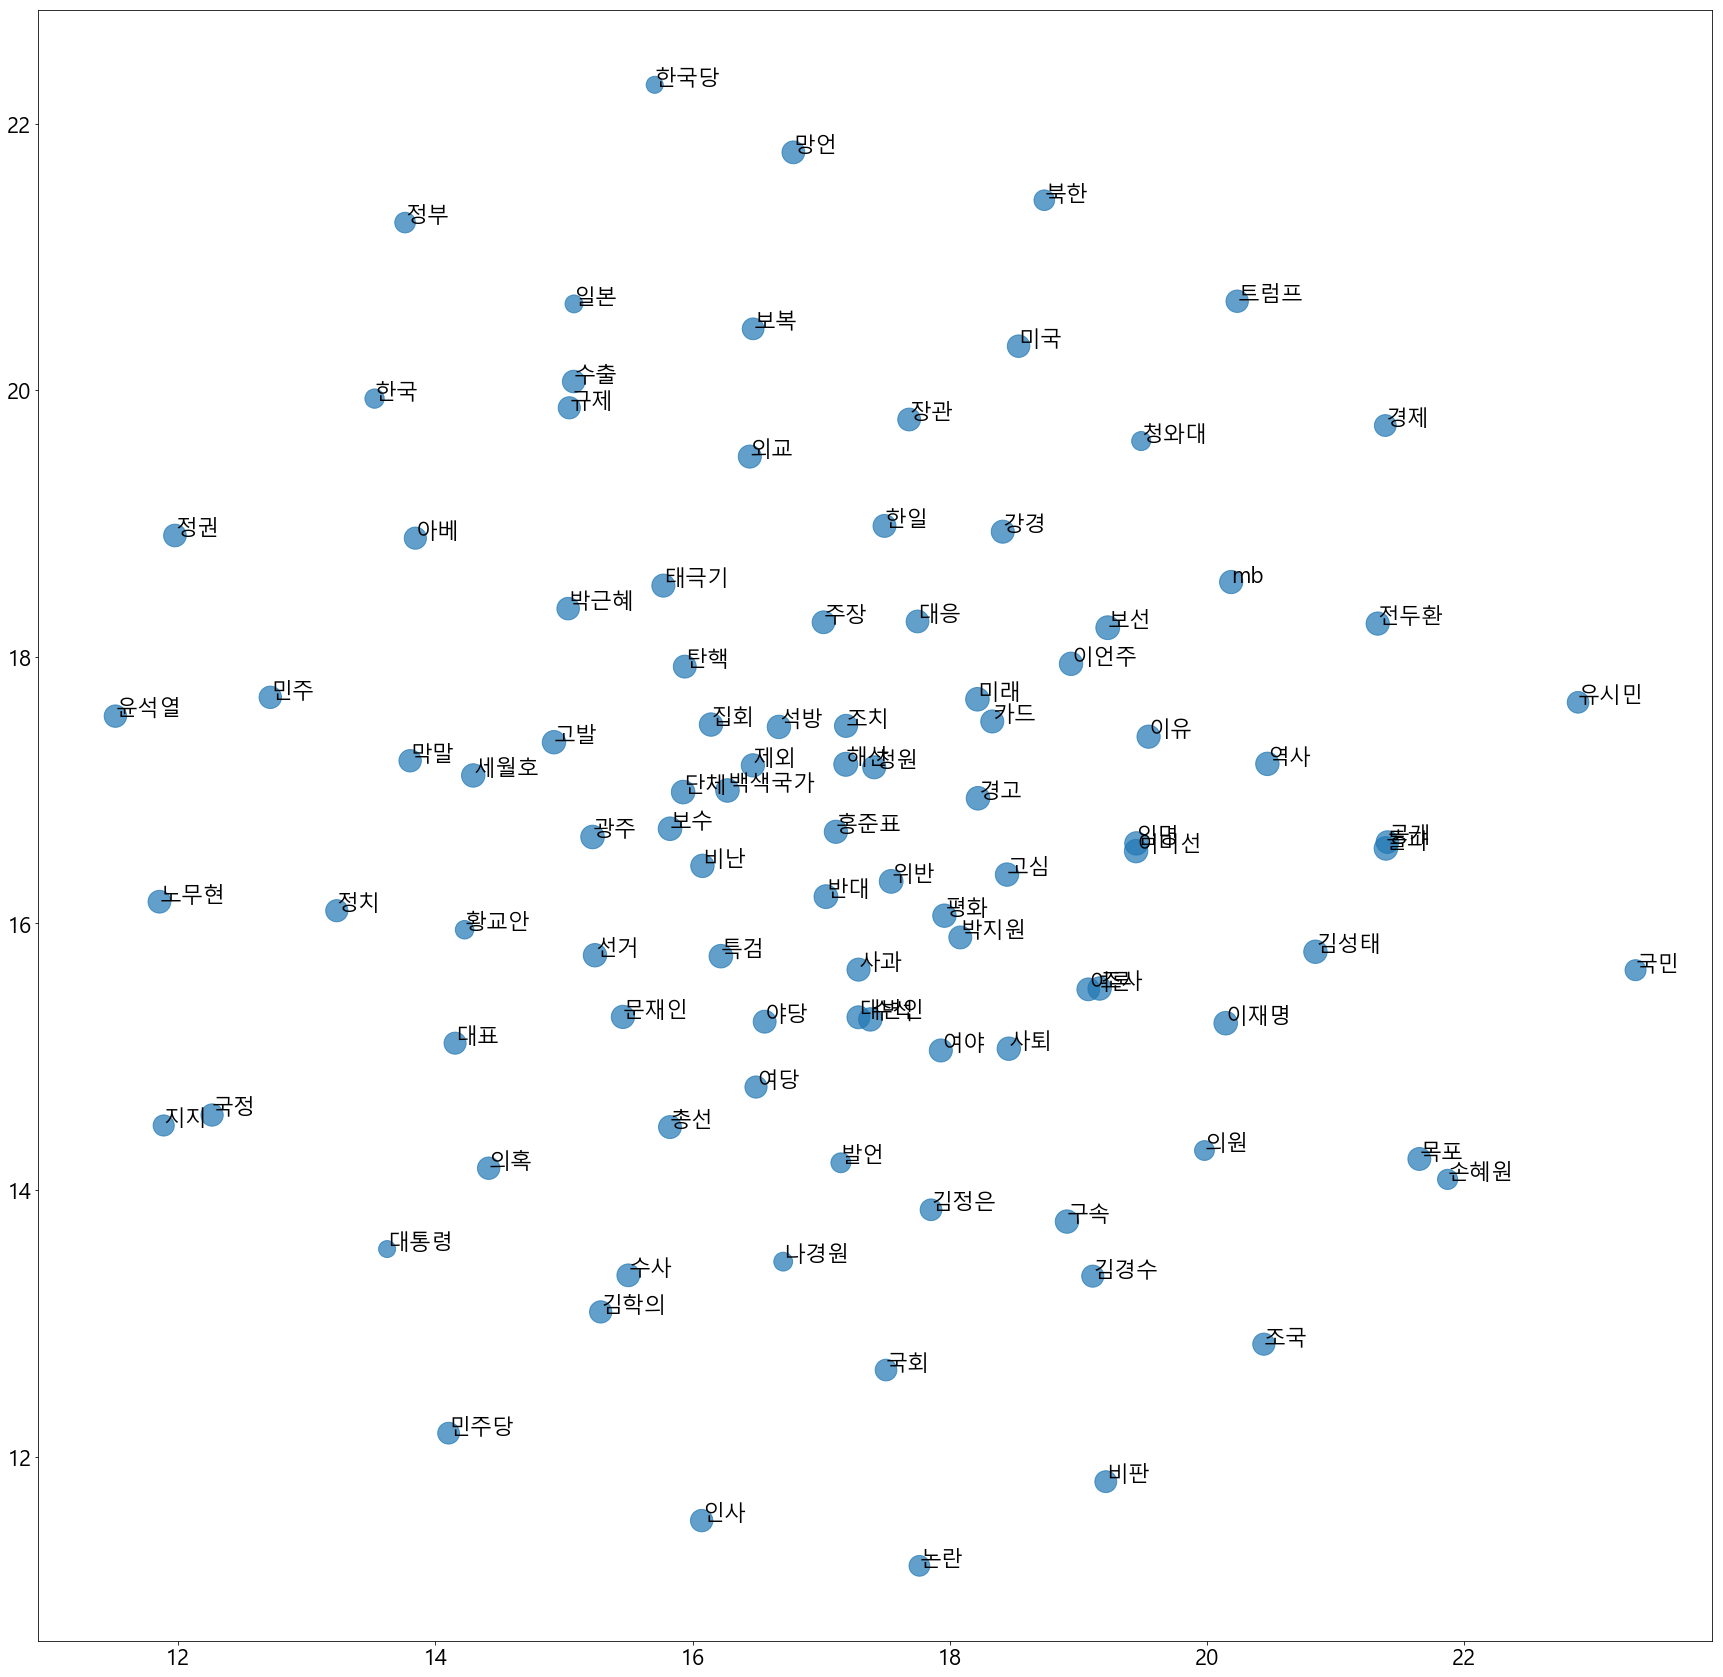

In [26]:
# TF-IDF score Top 100 단어 시각화

tsne = TSNE(n_components=2, n_iter=10000, verbose=1)
Z = tsne.fit_transform(data_array.T)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

import matplotlib as mpl
mpl.rcParams.update({'font.size': 22})

plt.figure(figsize=(30,30))
size = tfidf.idf_ * 100
plt.scatter(Z[:,0], Z[:,1], s=size, alpha=.7)
for x, y, name in zip(Z[:,0], Z[:,1], tfidf_dict):
    plt.text(x, y, name)
plt.show()